# Проект в рамках курса "Интерпретируемый ИИ и майнинг данных"
---

Проект выполнили:

## Первая часть проекта (работа с табличными данными):
Описание: 

### 1. Поиск причинно-следственных связей:

1.1 Рассмотреть модель на основе ваших предположений (ориентированных граф без циклов), словами описать, какие зависимости вы рассматривали. Изобразить граф, который вы рассматривали.

1.2 Применить 3 любых “refutation” метода на ваш выбор и обосновать их выбор (какие цели вы преследовали, выбирая эти методы, что вы хотели проверить)

In [38]:
import pandas as pd
from sklearn.model_selection import train_test_split
import pygraphviz
import dowhy
from dowhy import CausalModel

In [2]:
data = pd.read_csv('data/financial_data.csv', index_col=0)
data = data.drop(['price_to_sales', 'target'], axis=1)
data = data.dropna()

In [13]:
data.head()

,debt_to_equity,current_ratio,cash_ratio,return_on_assets,eps,price_to_casflow,shareholder_equity,interest_coverage,net_profit_margin,regression_target,SP_target
MMM,2.815404,0.421861,0.123210,0.031130,157.000000,0.563128,0.261732,-15.062500,0.169222,0.771223,True
ABT,1.193143,0.464377,0.119633,0.017844,0.051254,1247.571550,0.454586,-10.562044,0.139162,0.987052,False
ABBV,8.797119,0.171285,0.058735,0.015426,128.222222,0.257674,0.102058,-5.630159,0.178887,0.740247,True
ACN,1.108094,0.938716,0.433120,0.039204,20837.166667,0.011085,0.467920,-213.538401,0.127551,0.772344,True
AES,15.036926,0.195294,0.049944,-0.009718,-41.625000,0.111457,0.058482,-2.465517,-0.130845,0.704863,True


In [21]:
data_refutation = data.copy(deep=True)
data_refutation['SP_target'].replace({0: False, 1: True}, inplace=True)

In [39]:
data_refutation.columns

Index(['debt_to_equity', 'current_ratio', 'cash_ratio', 'return_on_assets',
       'eps', 'price_to_casflow', 'shareholder_equity', 'interest_coverage',
       'net_profit_margin', 'regression_target', 'SP_target'],
      dtype='object')

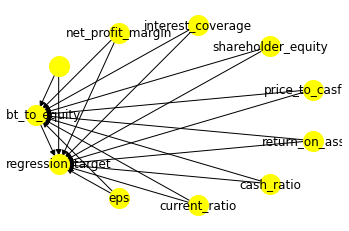

In [43]:
xs = ""
for i in [#'debt_to_equity',
        'eps',
        'current_ratio',
        'cash_ratio',
        'return_on_assets',
        'price_to_casflow',
        'shareholder_equity',
        'interest_coverage',
        'net_profit_margin']:
    xs += (str(i)+"+")

model=CausalModel(
        data = data_refutation,
        treatment='debt_to_equity',
        outcome='regression_target',
        common_causes=xs.split('+')
        )

model.view_model(layout="dot")

In [44]:
identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)
print(identified_estimand)

Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
        d                                                                     
─────────────────(Expectation(regression_target|shareholder_equity,interest_co
d[debt_to_equity]                                                             

                                                                              
verage,return_on_assets,eps,price_to_casflow,cash_ratio,current_ratio,net_prof
                                                                              

           
it_margin))
           
Estimand assumption 1, Unconfoundedness: If U→{debt_to_equity} and U→regression_target then P(regression_target|debt_to_equity,shareholder_equity,interest_coverage,return_on_assets,eps,price_to_casflow,cash_ratio,current_ratio,net_profit_margin,U) = P(regression_target|debt_to_equity,shareholder_equity,interest_coverage,return_on_assets,eps,price_to_casflow,cash_ratio,current_ratio,net_pro

In [48]:
estimate = model.estimate_effect(identified_estimand,
                                 method_name="backdoor.linear_regression", target_units="ate")
# ATE = Average Treatment Effect
# ATT = Average Treatment Effect on Treated (i.e. those who were assigned a different room)
# ATC = Average Treatment Effect on Control (i.e. those who were not assigned a different room)
print(estimate)

*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
        d                                                                     
─────────────────(Expectation(regression_target|shareholder_equity,interest_co
d[debt_to_equity]                                                             

                                                                              
verage,return_on_assets,eps,price_to_casflow,cash_ratio,current_ratio,net_prof
                                                                              

           
it_margin))
           
Estimand assumption 1, Unconfoundedness: If U→{debt_to_equity} and U→regression_target then P(regression_target|debt_to_equity,shareholder_equity,interest_coverage,return_on_assets,eps,price_to_casflow,cash_ratio,current_ratio,net_profit_margin,U) = P(regression_target|debt_to_equity,shareholder_equity,interest_coverage,return_on_assets,eps,p

In [46]:
refute1_results=model.refute_estimate(identified_estimand, estimate,
        method_name="random_common_cause")
print(refute1_results)

Refute: Add a Random Common Cause
Estimated effect:0.00011886971130314894
New effect:7.811215864472754e-05



In [8]:
data_groups = pd.read_csv('data/S&P500-Info.csv', index_col=0)
merged = data.merge(data_groups[['Symbol', 'GICS Sector']], left_index=True, right_on='Symbol')
X = merged.drop('Symbol', axis=1).drop(['regression_target', 'SP_target'], axis=1)
target_reg = merged.regression_target
target_class = merged.SP_target * 1

In [5]:
X_train_df, X_test_df, y_train_reg, y_test_reg = train_test_split(X, target_reg.values, test_size=0.3, random_state=42)
_, _, y_train_class, y_test_class = train_test_split(X, target_class.values, test_size=0.3, random_state=42)

In [12]:
X_train = X_train_df.groupby('GICS Sector').transform(lambda x: (x - x.mean()) / x.std())
X_test_mean = X_test_df.merge(X_train_df.groupby('GICS Sector').mean(), left_on='GICS Sector', right_index=True)
X_test_mean_std = X_test_mean.merge(X_train_df.groupby('GICS Sector').std(), left_on='GICS Sector', right_index=True)
X_test_mean_std = X_test_mean_std.drop('GICS Sector', axis=1)
X_test = (X_test_mean_std.iloc[:, :9].values - X_test_mean_std.iloc[:, 9:18].values)/X_test_mean_std.iloc[:, 18:].values

# Regression 

#### LinearRegression

In [ ]:
reg_model = LinearRegression()
reg_model.fit(X_train, y_train_reg)
pred = reg_model.predict(X_test)

In [ ]:
print(f'Train MSE: {mean_squared_error(reg_model.predict(X_train), y_train_reg):.5}')
print(f'Test MSE: {mean_squared_error(pred, y_test_reg):.5}')

Train MSE: 0.028117
Test MSE: 0.052553


#### Ridge

In [ ]:
ridge_model = Ridge(alpha=2.0, random_state=42)
ridge_model.fit(X_train, y_train_reg)
pred = ridge_model.predict(X_test)

In [ ]:
print(f'Train MSE: {mean_squared_error(ridge_model.predict(X_train), y_train_reg):.5}')
print(f'Test MSE: {mean_squared_error(pred, y_test_reg):.5}')

Train MSE: 0.028117
Test MSE: 0.052999


#### Lasso

In [ ]:
lasso_model = Lasso(alpha=2.0, random_state=42)
lasso_model.fit(X_train, y_train_reg)
pred = lasso_model.predict(X_test)

In [ ]:
print(f'Train MSE: {mean_squared_error(lasso_model.predict(X_train), y_train_reg):.5}')
print(f'Test MSE: {mean_squared_error(pred, y_test_reg):.5}')

Train MSE: 0.031893
Test MSE: 0.031381


#### ElasticNet

In [ ]:
elastic_model = ElasticNet(alpha=2.0, random_state=42)
elastic_model.fit(X_train, y_train_reg)
pred = elastic_model.predict(X_test)

In [ ]:
print(f'Train MSE: {mean_squared_error(elastic_model.predict(X_train), y_train_reg):.5}')
print(f'Test MSE: {mean_squared_error(pred, y_test_reg):.5}')

Train MSE: 0.031893
Test MSE: 0.031381


#### SGDRegressor - l2

In [ ]:
SGD_model_l2 = SGDRegressor(loss='squared_loss', penalty='l2', alpha=20.0, random_state=42)
SGD_model_l2.fit(X_train, y_train_reg)
pred = SGD_model_l2.predict(X_test)

In [ ]:
print(f'Train MSE: {mean_squared_error(SGD_model_l2.predict(X_train), y_train_reg):.5}')
print(f'Test MSE: {mean_squared_error(pred, y_test_reg):.5}')

Train MSE: 0.031143
Test MSE: 0.03138


#### SGDRegressor - l1

In [ ]:
SGD_model_l1 = SGDRegressor(loss='squared_loss', penalty='l1', alpha=2.0, random_state=42)
SGD_model_l1.fit(X_train, y_train_reg)
pred = SGD_model_l1.predict(X_test)

In [ ]:
print(f'Train MSE: {mean_squared_error(SGD_model_l1.predict(X_train), y_train_reg):.5}')
print(f'Test MSE: {mean_squared_error(pred, y_test_reg):.5}')

Train MSE: 0.031935
Test MSE: 0.031524


#### RandomForestRegressor

In [ ]:
RF = RandomForestRegressor(criterion='mae', n_estimators=100, min_samples_leaf=1, max_depth=2, random_state=42)
RF.fit(X_train, y_train_reg)
pred = RF.predict(X_test)

In [ ]:
print(f'Train MSE: {mean_squared_error(RF.predict(X_train), y_train_reg):.5}')
print(f'Test MSE: {mean_squared_error(pred, y_test_reg):.5}')

Train MSE: 0.023802
Test MSE: 0.032969


In [ ]:
RF = RandomForestRegressor(criterion='mse', n_estimators=150, min_samples_leaf=1, max_depth=2, random_state=42)
RF.fit(X_train, y_train_reg)
pred = RF.predict(X_test)

In [ ]:
print(f'Train MSE: {mean_squared_error(RF.predict(X_train), y_train_reg):.5}')
print(f'Test MSE: {mean_squared_error(pred, y_test_reg):.5}')

Train MSE: 0.023353
Test MSE: 0.032984


#### XGBoost

In [ ]:
XGB_model = xg.XGBRegressor(objective ='reg:squarederror', n_estimators=50, max_depth=1, learning_rate=0.05, seed=42)
XGB_model.fit(X_train, y_train_reg)
pred = XGB_model.predict(X_test)

In [ ]:
print(f'Train MSE: {mean_squared_error(XGB_model.predict(X_train), y_train_reg):.5}')
print(f'Test MSE: {mean_squared_error(pred, y_test_reg):.5}')

Train MSE: 0.025938
Test MSE: 0.033233


#### CatBoost

In [ ]:
CB_model = CatBoostRegressor(learning_rate=1e-5, loss_function='MAE', depth=2, random_seed=42)
CB_model.fit(X_train, y_train_reg, verbose=False)
pred = CB_model.predict(X_test)

In [ ]:
print(f'Train MSE: {mean_squared_error(CB_model.predict(X_train), y_train_reg):.5}')
print(f'Test MSE: {mean_squared_error(pred, y_test_reg):.5}')

Train MSE: 0.031839
Test MSE: 0.031351


In [ ]:
CB_model = CatBoostRegressor(learning_rate=1e-5, loss_function='RMSE', depth=2, random_seed=42)
CB_model.fit(X_train, y_train_reg, verbose=False)
pred = CB_model.predict(X_test)

In [ ]:
print(f'Train MSE: {mean_squared_error(CB_model.predict(X_train), y_train_reg):.5}')
print(f'Test MSE: {mean_squared_error(pred, y_test_reg):.5}')

Train MSE: 0.03183
Test MSE: 0.031375


#### NN

In [ ]:
NN_model = MLPRegressor(hidden_layer_sizes=(50, 100, 50), learning_rate_init=0.1, solver='adam', random_state=42)
NN_model.fit(X_train, y_train_reg)
pred = NN_model.predict(X_test)

In [ ]:
print(f'Train MSE: {mean_squared_error(NN_model.predict(X_train), y_train_reg):.5}')
print(f'Test MSE: {mean_squared_error(pred, y_test_reg):.5}')

Train MSE: 0.030467
Test MSE: 0.03192


# Classification

In [1]:
import xgboost as xg
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, SGDRegressor, LogisticRegression, SGDClassifier
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.neural_network import MLPRegressor, MLPClassifier
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.model_selection import GridSearchCV
from catboost import CatBoostRegressor, CatBoostClassifier

#### LogisticRegression

In [ ]:
LR_model = LogisticRegression(penalty='l2', random_state=42)
LR_model.fit(X_train, y_train_class)
pred = LR_model.predict(X_test)

In [ ]:
print(f'Train Accuracy: {accuracy_score(LR_model.predict(X_train), y_train_class) * 100:.4}')
print(f'Test Accuracy: {accuracy_score(pred, y_test_class) * 100:.4}')

Train Accuracy: 64.75
Test Accuracy: 58.1


#### SGDClassifier

In [ ]:
SGDClassifier_model = SGDClassifier(loss='perceptron', penalty='l2', random_state=42)
SGDClassifier_model.fit(X_train, y_train_class)
pred = SGDClassifier_model.predict(X_test)

In [ ]:
print(f'Train Accuracy: {accuracy_score(SGDClassifier_model.predict(X_train), y_train_class) * 100:.4}')
print(f'Test Accuracy: {accuracy_score(pred, y_test_class) * 100:.4}')

Train Accuracy: 58.61
Test Accuracy: 60.0


#### RandomForestClassifier

In [ ]:
RF_model = RandomForestClassifier(n_estimators=100, criterion='gini', min_samples_leaf=7, max_depth=2, random_state=42)
RF_model.fit(X_train, y_train_class)
pred = RF_model.predict(X_test)

In [ ]:
print(f'Train Accuracy: {accuracy_score(RF_model.predict(X_train), y_train_class) * 100:.4}')
print(f'Test Accuracy: {accuracy_score(pred, y_test_class) * 100:.4}')

Train Accuracy: 70.9
Test Accuracy: 65.71


#### XGBoost

In [ ]:
XGB_model = xg.XGBClassifier(n_estimators=100, max_depth=2, learning_rate=0.0005, use_label_encoder=False, random_state=42)
XGB_model.fit(X_train, y_train_class)
pred = XGB_model.predict(X_test)

[23:50:51] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [ ]:
print(f'Train Accuracy: {accuracy_score(XGB_model.predict(X_train), y_train_class) * 100:.4}')
print(f'Test Accuracy: {accuracy_score(pred, y_test_class) * 100:.4}')

Train Accuracy: 69.26
Test Accuracy: 61.9


#### CatBoost

In [ ]:
CB_model = CatBoostClassifier(learning_rate=1e-4, depth=3, random_seed=42)
CB_model.fit(X_train, y_train_class, verbose=False)
pred = CB_model.predict(X_test)

In [ ]:
print(f'Train Accuracy: {accuracy_score(CB_model.predict(X_train), y_train_class) * 100:.4}')
print(f'Test Accuracy: {accuracy_score(pred, y_test_class) * 100:.4}')

Train Accuracy: 70.08
Test Accuracy: 63.81


#### NN

In [ ]:
NN_model = MLPClassifier(hidden_layer_sizes=(50, 100, 50), alpha=0, learning_rate_init=0.5,
                         max_iter=1500, solver='adam')
NN_model.fit(X_train, y_train_class)
pred = NN_model.predict(X_test)

In [ ]:
print(f'Train Accuracy: {accuracy_score(NN_model.predict(X_train), y_train_class) * 100:.4}')
print(f'Test Accuracy: {accuracy_score(pred, y_test_class) * 100:.4}')

Train Accuracy: 60.66
Test Accuracy: 60.95
